In [431]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,  roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Unsupervised Learning

Unsupervised learning - Apply unsupervised learning to explore whether the \
intrinsic structure of the gene expression data naturally reflects the known \
cancer subtypes. Use dimensionality reduction techniques (e.g PCA or UMAP) for \
visualization and clustering algorithms (e.g K-means, hierarchical clustering). \
Are the subtypes of cancer (Classical and Mesenchymal) recapitulated using these \
methods? Generate visualizations using the results from these methods.

In [432]:
# Load your gene expression dataset
# Assume `X` is the gene expression matrix (samples x genes)
# and `labels` contains known subtypes: ['Classical', 'Mesenchymal']
X = pd.read_csv("datasets/X_gexp.csv", index_col=0)
labels = pd.read_csv("datasets/y_gexp.csv", index_col=0).values.ravel()

# Standardize
X_std = (X - X.mean()) / X.std()

# --------------------
# Dimensionality Reduction
# --------------------
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# UMAP
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_std)


/Users/gdsantos/Desktop/University/MCC/2A_2S/Bioinformática/Group_Assignment_2/bioinformatics_ml/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gdsantos/Desktop/University/MCC/2A_2S/Bioinformática/Group_Assignment_2/bioinformatics_ml/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Application of kmeans algorithm looking for two differents clusters, adequade for a binary classification

In [433]:
# --------------------
# Clustering
# --------------------
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_std)

hierarchical = AgglomerativeClustering(n_clusters=2)
hier_labels = hierarchical.fit_predict(X_std)

In [434]:
# --------------------
# Evaluation (if labels known)
# --------------------
ari_kmeans = adjusted_rand_score(labels, kmeans_labels)
nmi_kmeans = normalized_mutual_info_score(labels, kmeans_labels)

ari_hier = adjusted_rand_score(labels, hier_labels)
nmi_hier = normalized_mutual_info_score(labels, hier_labels)

print(f"KMeans - ARI: {ari_kmeans:.2f}, NMI: {nmi_kmeans:.2f}")
print(f"Hierarchical - ARI: {ari_hier:.2f}, NMI: {nmi_hier:.2f}")



KMeans - ARI: 0.04, NMI: 0.03
Hierarchical - ARI: 0.00, NMI: 0.00


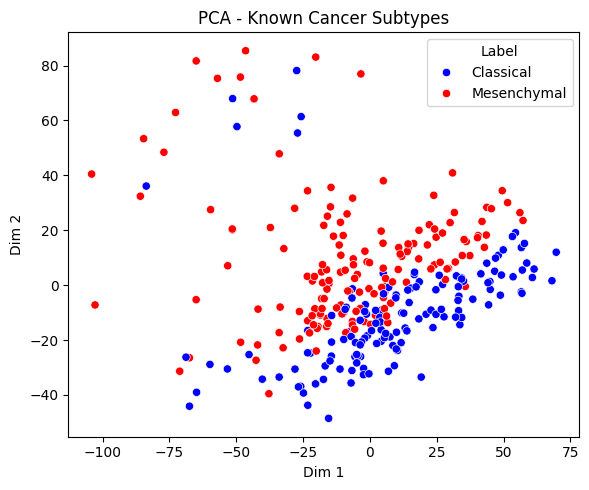

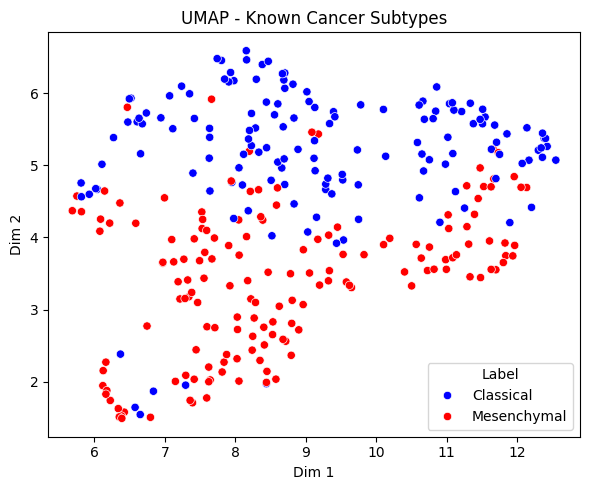

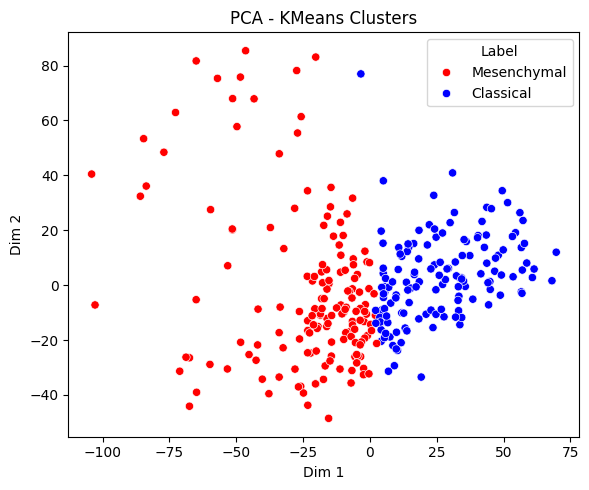

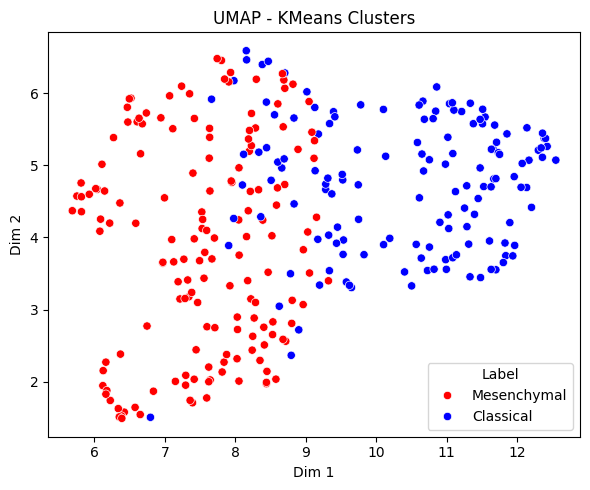

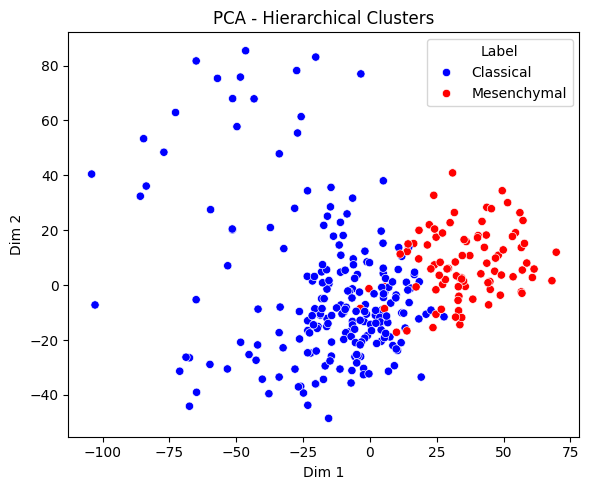

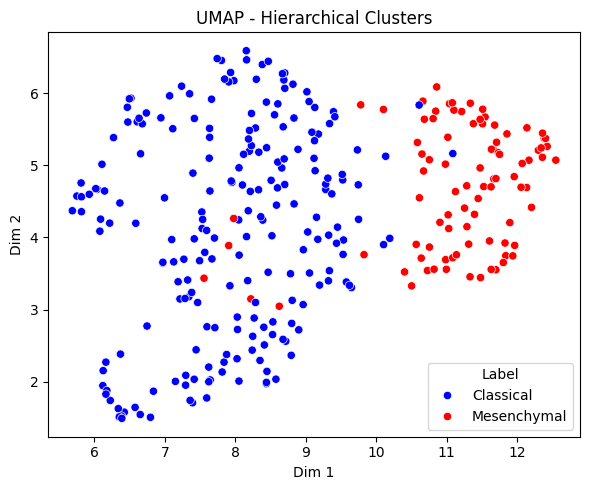

In [435]:
# --------------------
# Visualization
# --------------------
def plot_embedding(X_embed, labels, title, is_subtype=False):
    plt.figure(figsize=(6,5))
    
    if is_subtype:
        # Map 0 → Classical, 1 → Mesenchymal
        label_names = np.array(["Classical", "Mesenchymal"])
        labels_named = label_names[labels]
        palette = {"Classical": "blue", "Mesenchymal": "red"}
    else:
        labels_named = labels
        palette = sns.color_palette("Set1", n_colors=len(np.unique(labels)))
    
    sns.scatterplot(x=X_embed[:, 0], y=X_embed[:, 1], hue=labels_named, palette=palette)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend(title="Label")
    plt.tight_layout()
    plt.show()

# Plot PCA / UMAP colored by known subtypes
plot_embedding(X_pca, labels, "PCA - Known Cancer Subtypes", is_subtype=True)
plot_embedding(X_umap, labels, "UMAP - Known Cancer Subtypes", is_subtype=True)

# Plot PCA / UMAP colored by KMeans clusters
plot_embedding(X_pca, kmeans_labels, "PCA - KMeans Clusters", is_subtype=True)
plot_embedding(X_umap, kmeans_labels, "UMAP - KMeans Clusters", is_subtype=True)

# Plot PCA / UMAP colored by Hierarchical Clusters
plot_embedding(X_pca, hier_labels, "PCA - Hierarchical Clusters", is_subtype=True)
plot_embedding(X_umap, hier_labels, "UMAP - Hierarchical Clusters", is_subtype=True)

# Supervised Learning

Build a binary classifier capable of distinguishing between the Classical \
(prognostically favourable) and Mesenchymal (prognostically adverse) subtypes. \
A possible pipeline for this task is outlined below and should guide you in building \
and evaluating your subtype classification model using gene expression data

## Data Preprocessing

Loading data and Encoding data

In [436]:
# --------------------
# Load Data
# --------------------
X = pd.read_csv("datasets/X_gexp.csv", index_col=0)
y = pd.read_csv("datasets/y_gexp.csv", index_col=0).values.ravel()

## Train and Test Split

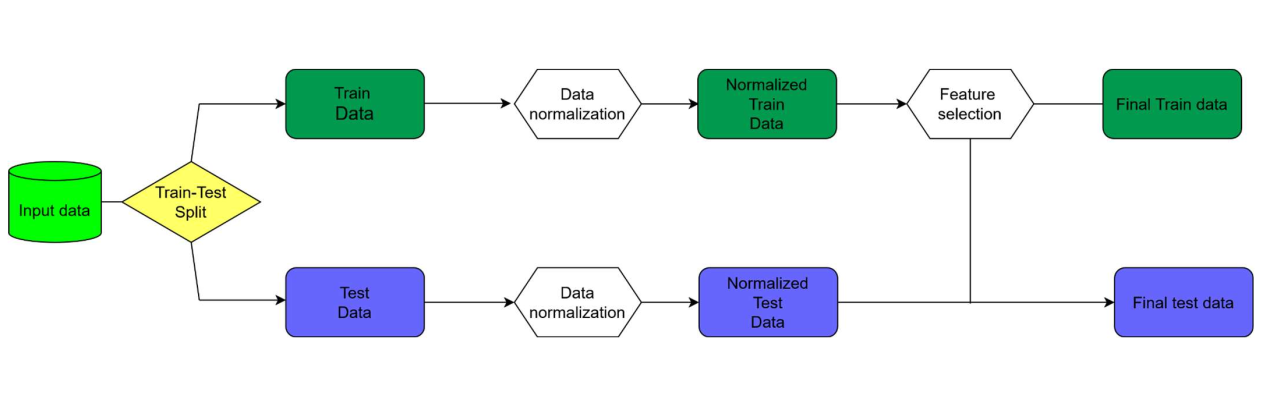


In [437]:
# --------------------
# Train-Test Split
# --------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

In [438]:
# --------------------
# Standardization (Before Feature Selection)
# --------------------

def standardization(data):
    return (data - data.mean()) / data.std()

def normalization(data):
    return (data - data.min())/(data.max() - data.min())


Selecting the most relevants features

In [439]:
# --------------------
# Feature Selection on Training Data
# --------------------

def feature_selection( train, test, threshold = 0.01, select_k = 100, data=X):
    vt = VarianceThreshold(threshold=threshold)
    X_train_vt = vt.fit_transform(train)
    X_test_vt = vt.transform(test)

    # Obter os nomes das features após o VarianceThreshold
    vt_feature_names = data.columns[vt.get_support()]
    X_train_vt_df = pd.DataFrame(X_train_vt, columns=vt_feature_names)

    # Selecionar as top 100 features com ANOVA F-test
    
    fs = SelectKBest(score_func=f_classif, k=select_k)
    X_train_selected = fs.fit_transform(X_train_vt_df, y_train)
    X_test_selected = fs.transform(pd.DataFrame(X_test_vt, columns=vt_feature_names))

    # Obter os nomes das 100 features selecionadas
    selected_feature_names = vt_feature_names[fs.get_support()]
    return X_train_selected, X_train_vt_df, X_test_selected, selected_feature_names

# --------------------
# Visualização: Boxplot das features selecionadas
# --------------------

def plot_feature_selection(train, X_train_vt_df, y_train, selected_feature_names, full_data, threshold = 0.01):
    # --------------------
    # Variance Plot (all features vs. selected)
    # --------------------
    feature_variances = full_data.var()
    plt.figure(figsize=(14, 6))
    bars = plt.bar(feature_variances.index, feature_variances.values, color='lightgray', )

    for i, feature in enumerate(feature_variances.index):
        if feature in selected_feature_names:
            bars[i].set_color('steelblue')

    plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
    plt.xticks(rotation=90)
    plt.ylabel('Variance')
    plt.title('Feature Variance and Selection by VarianceThreshold')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --------------------
    # Boxplot of Selected Top 20 Variance Features
    # --------------------
    selected_df = X_train_vt_df[selected_feature_names].copy()
    selected_df["Subtype"] = y_train

    long_df = pd.melt(selected_df, id_vars="Subtype", var_name="Gene", value_name="Expression")
    top20_genes = selected_df.drop(columns="Subtype").var().sort_values(ascending=False).head(20).index
    top20_df = long_df[long_df["Gene"].isin(top20_genes)]

    plt.figure(figsize=(14, 8))
    sns.boxplot(data=top20_df, x="Gene", y="Expression", hue="Subtype")
    plt.xticks(rotation=90)
    plt.title("Top 20 Variance Features (Among Selected) by Subtype")
    plt.tight_layout()
    plt.show()


    # --------------------
    # Visualization: Correlation Heatmap
    # --------------------
    plt.figure(figsize=(12, 10))
    sns.heatmap(selected_df.corr(), annot=False, fmt=".2f", cmap="coolwarm", square=True,
                cbar_kws={'label': 'Pearson Correlation'})
    plt.title("Correlation Heatmap - Top 100 Features (Selected by ANOVA F-test)")
    plt.tight_layout()
    plt.show()

    # --------------------
    # Random Forest Feature Importance
    # --------------------
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(train, y_train)

    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': train.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print("\nTop 20 Feature Importances (Random Forest):")
    print(feature_importance_df.head(20))

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(20), palette="viridis")
    plt.title("Top 20 Feature Importances - Random Forest")
    plt.tight_layout()
    plt.show()

# Using Standadization 

In [440]:
X_train_scaled = standardization(X_train)
X_test_scaled = standardization(X_test)


X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

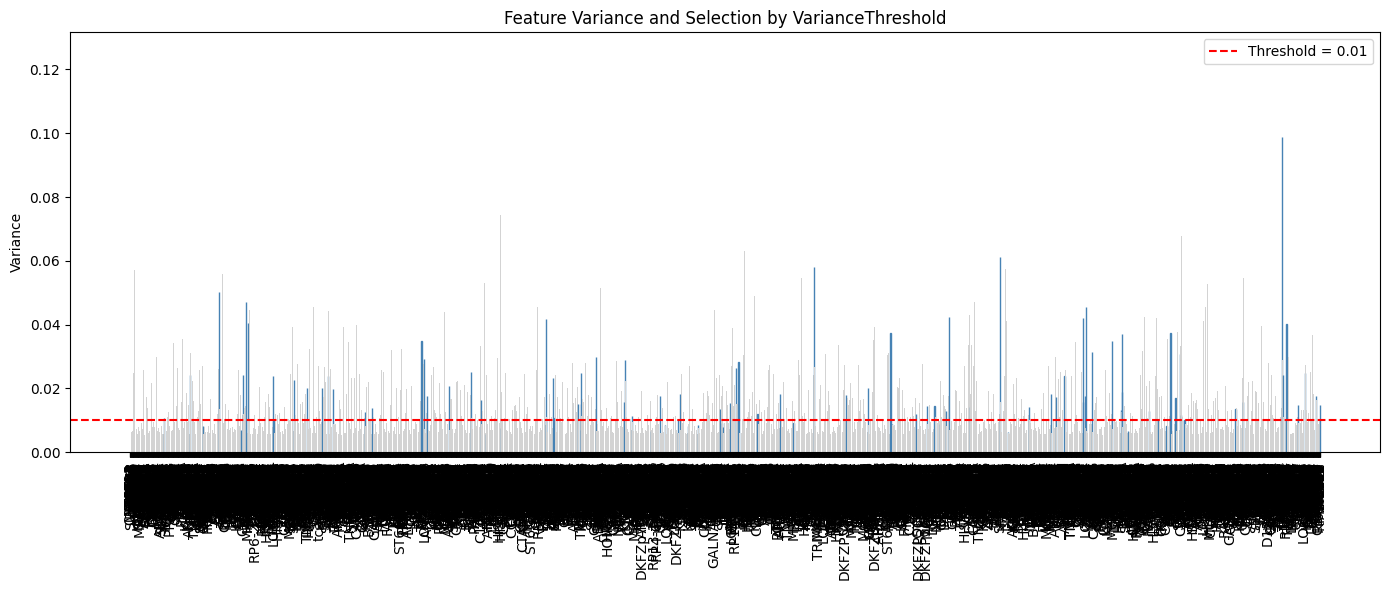

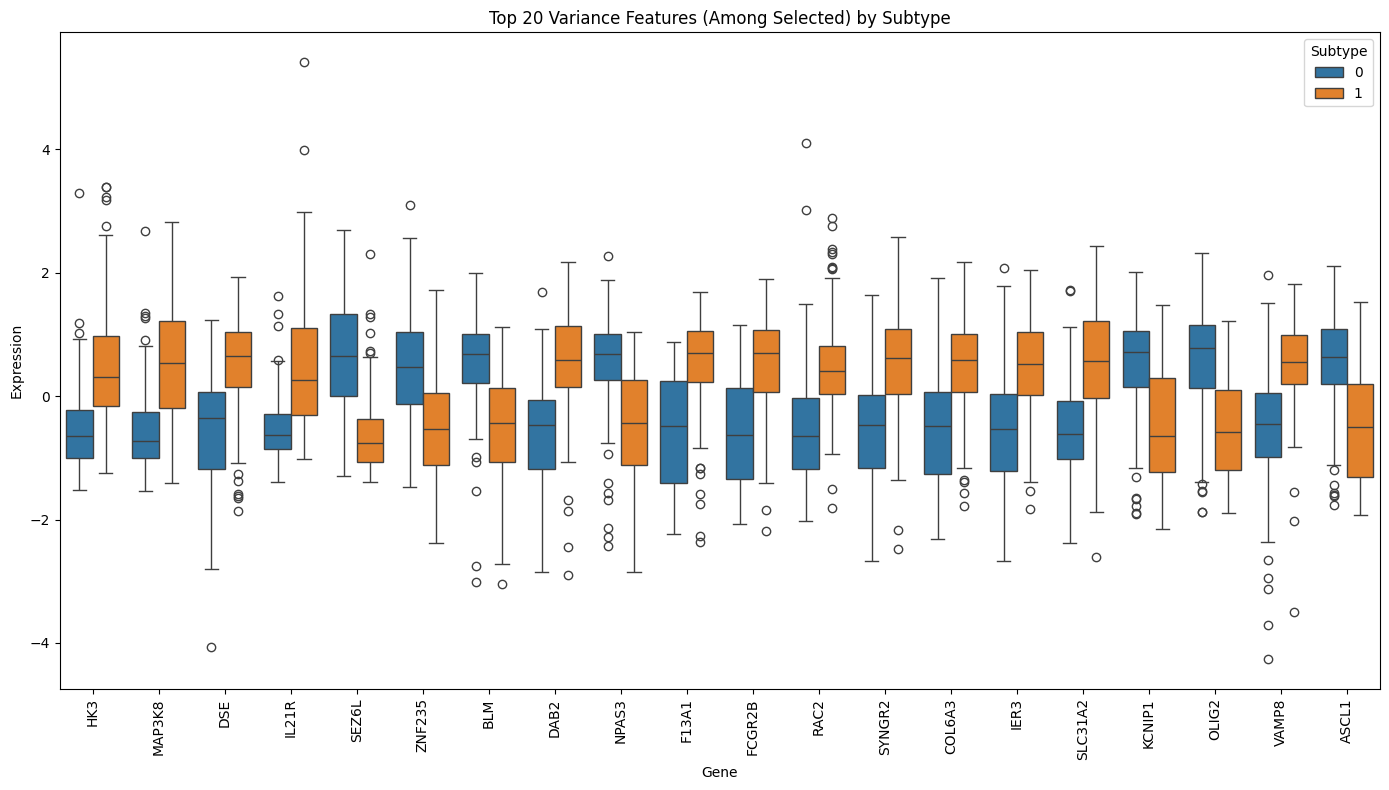

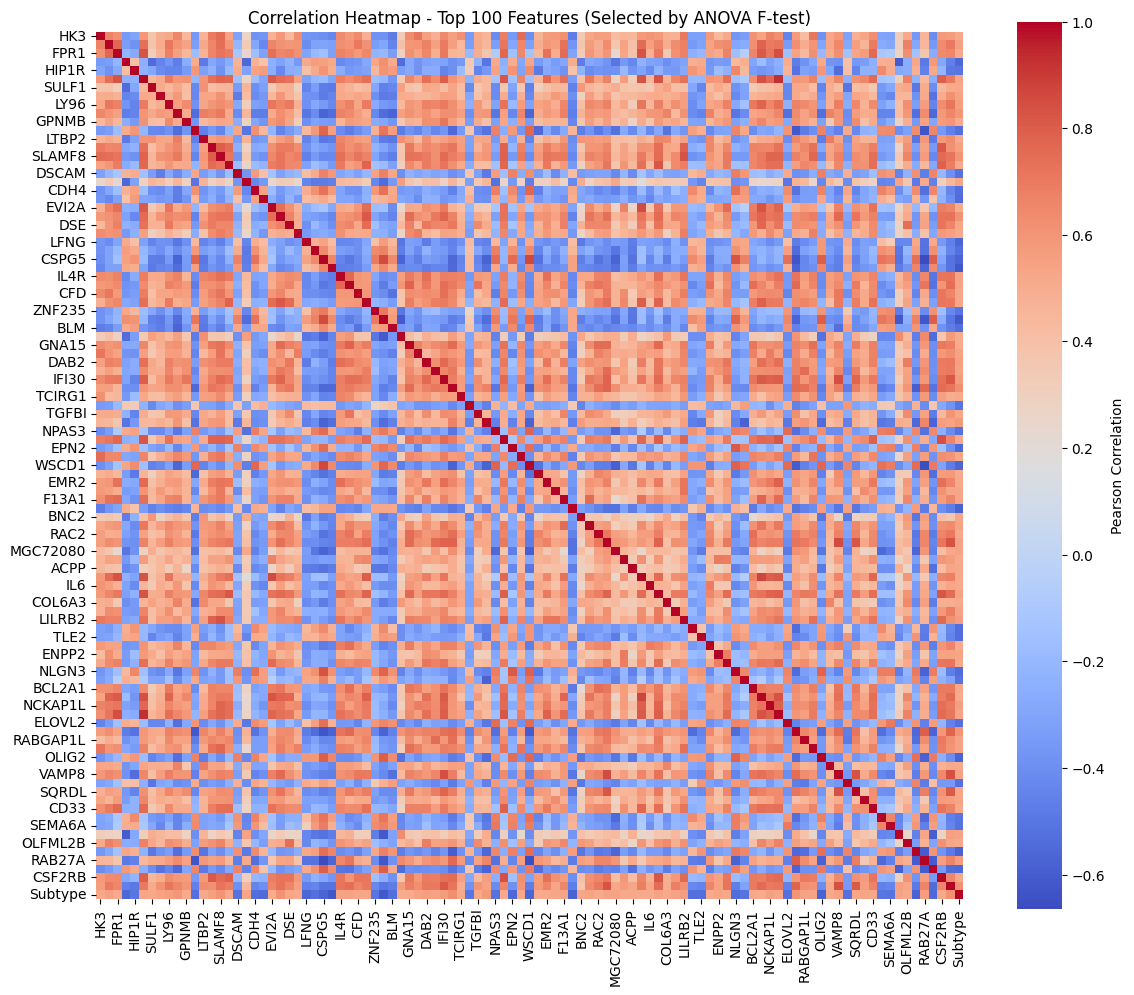


Top 20 Feature Importances (Random Forest):
       Feature  Importance
2487     GCNT1    0.020827
1749     CSPG5    0.020782
2302     IFI30    0.018501
2312   TNFAIP8    0.017412
4999      CTSC    0.015672
3777    LILRB2    0.012623
296       DPP6    0.012620
4163   NCKAP1L    0.012100
4904    RAB27A    0.009549
1382      GMFG    0.009474
4353     OLIG2    0.009222
3293    MS4A6A    0.008948
1434      CSTA    0.008943
4391     VAMP8    0.008886
4280  RABGAP1L    0.007943
3428      AIF1    0.007344
2556     WSCD1    0.007023
1055    CENTA2    0.006876
3009      GAS1    0.006518
2772    IL15RA    0.006428


/var/folders/7_/dhch1whn1nvc26xrz2l7ycjm0000gn/T/ipykernel_99724/277010722.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(20), palette="viridis")


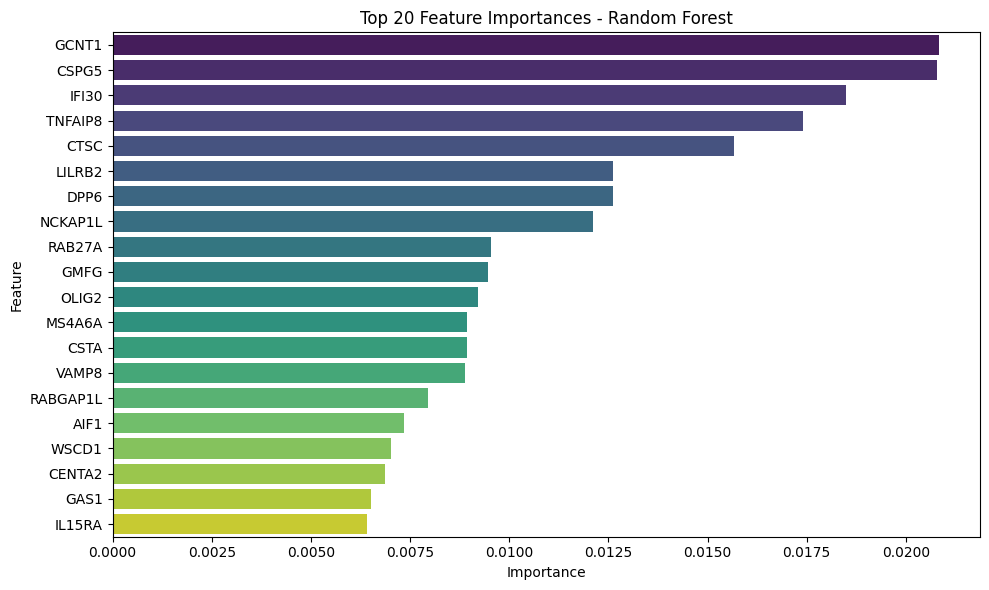

In [441]:
X_train_selected, X_vt_df, X_test_selected, selected_feature_names = feature_selection(X_train_scaled_df, X_test_scaled_df)
plot_feature_selection(X_train_scaled_df, X_vt_df, y_train, selected_feature_names, X)

In [442]:
# --------------------
# Classifier
# --------------------
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_selected, y_train)
y_pred = clf.predict(X_test_selected)
y_proba = clf.predict_proba(X_test_selected)[:, 1]

Logistic Regression - Test Evaluation:
              precision    recall  f1-score   support

   Classical       0.90      0.97      0.93        29
 Mesenchymal       0.97      0.91      0.94        32

    accuracy                           0.93        61
   macro avg       0.93      0.94      0.93        61
weighted avg       0.94      0.93      0.93        61

ROC AUC: 0.985


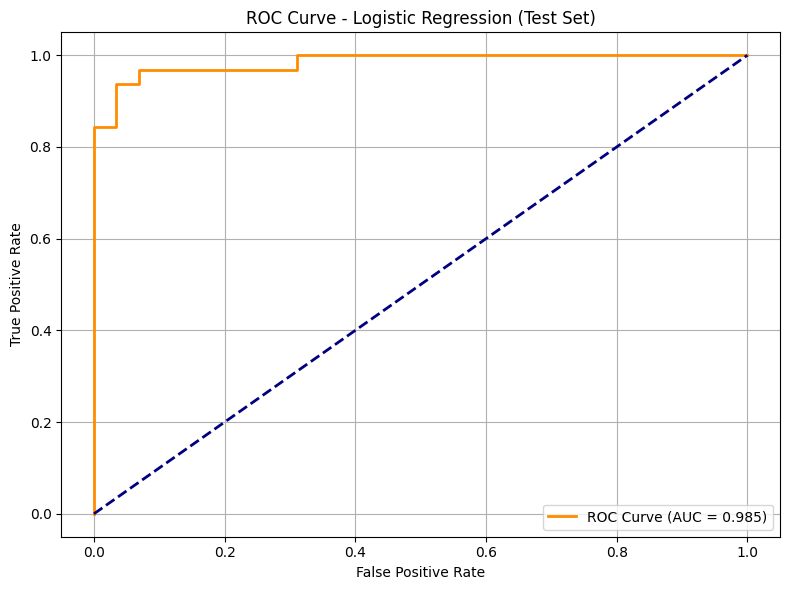

In [443]:
# --------------------
# Evaluation with ROC Curve Plot
# --------------------
from sklearn.metrics import roc_curve, auc

print("Logistic Regression - Test Evaluation:")
print(classification_report(y_test, y_pred, target_names=["Classical", "Mesenchymal"]))
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.3f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Logistic Regression - Test Evaluation:
              precision    recall  f1-score   support

   Classical       0.90      0.97      0.93        29
 Mesenchymal       0.97      0.91      0.94        32

    accuracy                           0.93        61
   macro avg       0.93      0.94      0.93        61
weighted avg       0.94      0.93      0.93        61

ROC AUC: 0.985


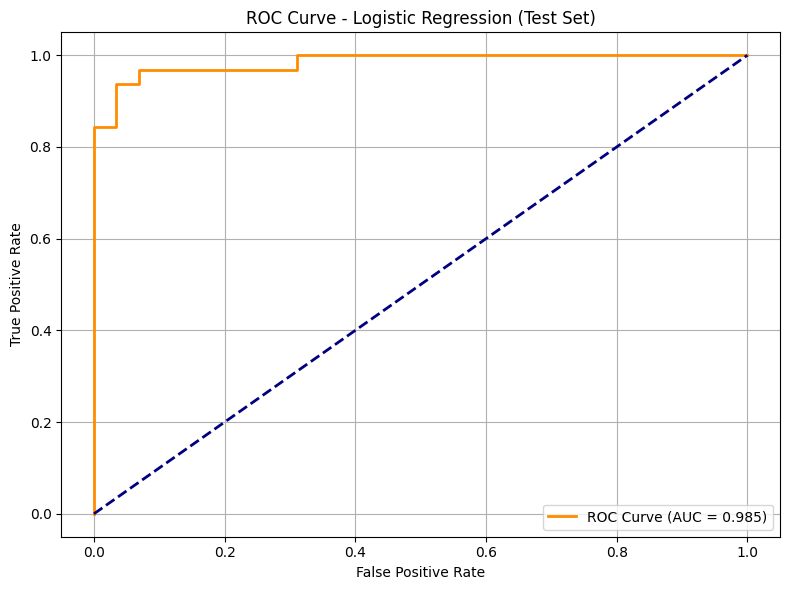

<Figure size 600x500 with 0 Axes>

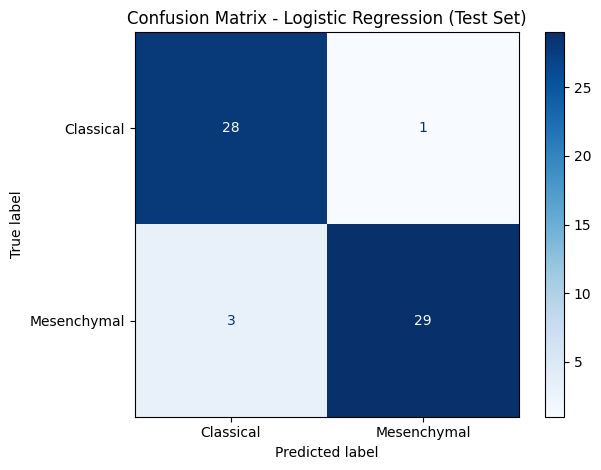

In [444]:
# --------------------# --------------------
# Evaluation with ROC Curve Plot
# --------------------
from sklearn.metrics import roc_curve, auc

print("Logistic Regression - Test Evaluation:")
print(classification_report(y_test, y_pred, target_names=["Classical", "Mesenchymal"]))
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.3f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
# Confusion Matrix Plot
# --------------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Classical", "Mesenchymal"])

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Logistic Regression (Test Set)")
plt.tight_layout()
plt.show()

## Using Normalization (min-max scaling)

In [445]:
X_train_norm = standardization(X_train)
X_test_norm = standardization(X_test)


X_train_norm_df = pd.DataFrame(X_train_norm, columns=X.columns, index=X_train.index)
X_test_norm_df = pd.DataFrame(X_test_norm, columns=X.columns, index=X_test.index)

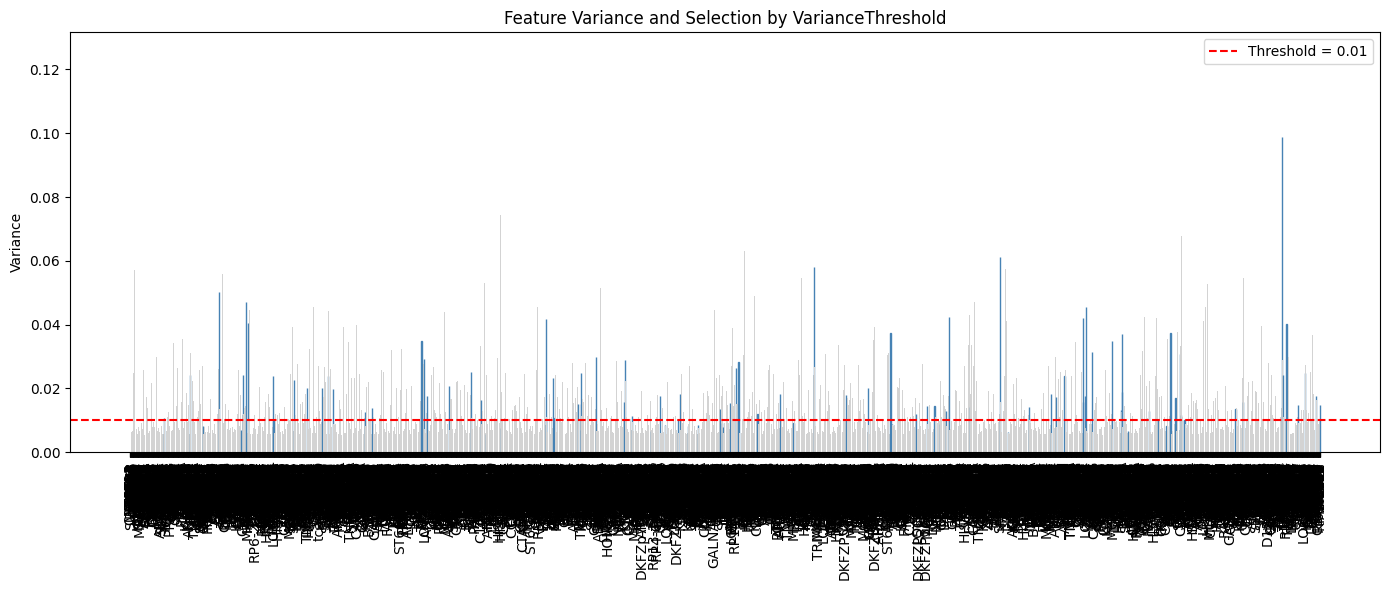

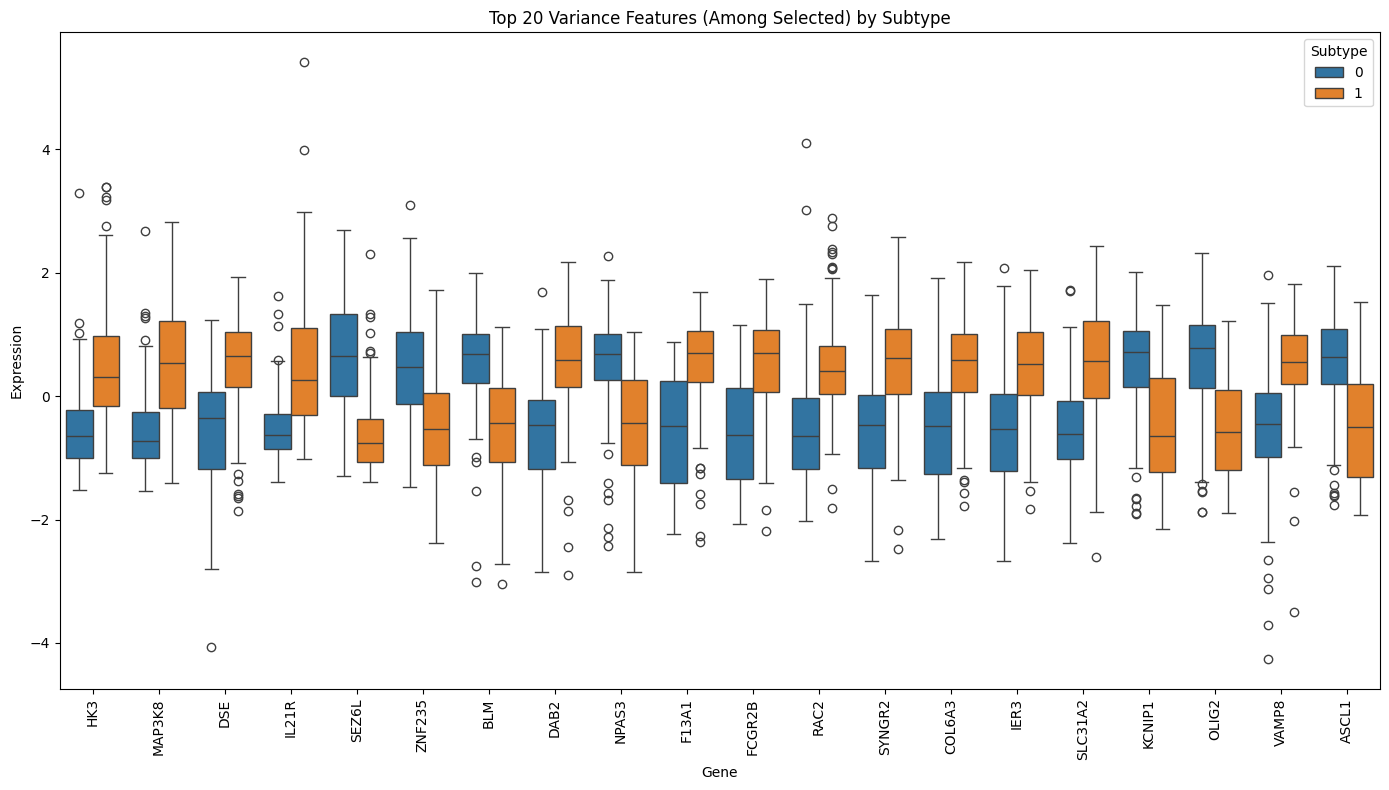

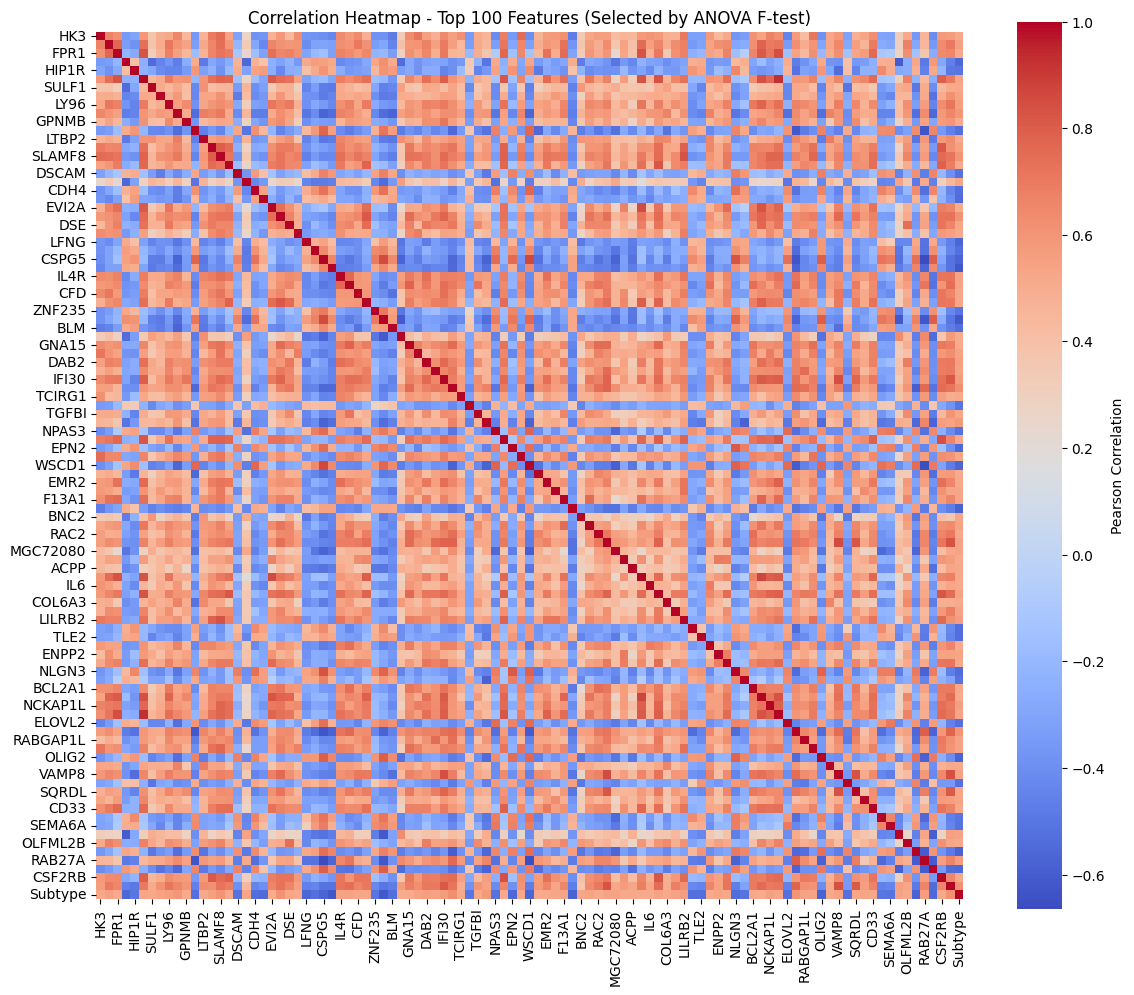


Top 20 Feature Importances (Random Forest):
       Feature  Importance
2487     GCNT1    0.020827
1749     CSPG5    0.020782
2302     IFI30    0.018501
2312   TNFAIP8    0.017412
4999      CTSC    0.015672
3777    LILRB2    0.012623
296       DPP6    0.012620
4163   NCKAP1L    0.012100
4904    RAB27A    0.009549
1382      GMFG    0.009474
4353     OLIG2    0.009222
3293    MS4A6A    0.008948
1434      CSTA    0.008943
4391     VAMP8    0.008886
4280  RABGAP1L    0.007943
3428      AIF1    0.007344
2556     WSCD1    0.007023
1055    CENTA2    0.006876
3009      GAS1    0.006518
2772    IL15RA    0.006428


/var/folders/7_/dhch1whn1nvc26xrz2l7ycjm0000gn/T/ipykernel_99724/277010722.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(20), palette="viridis")


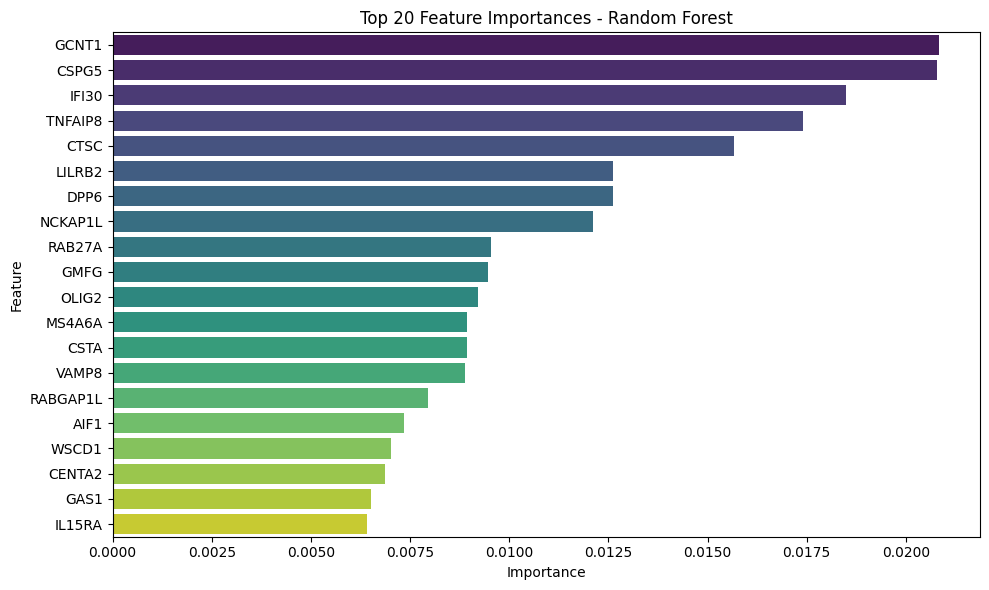

In [446]:
X_train_selected, X_train_vt_df, X_test_selected, selected_feature_names = feature_selection(X_train_norm_df, X_test_norm_df)
plot_feature_selection(X_train_norm_df, X_train_vt_df, y_train, selected_feature_names, X)

In [447]:
# --------------------
# Classifier
# --------------------
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_selected, y_train)
y_pred = clf.predict(X_test_selected)
y_proba = clf.predict_proba(X_test_selected)[:, 1]

Logistic Regression - Test Evaluation:
              precision    recall  f1-score   support

   Classical       0.90      0.97      0.93        29
 Mesenchymal       0.97      0.91      0.94        32

    accuracy                           0.93        61
   macro avg       0.93      0.94      0.93        61
weighted avg       0.94      0.93      0.93        61

ROC AUC: 0.985


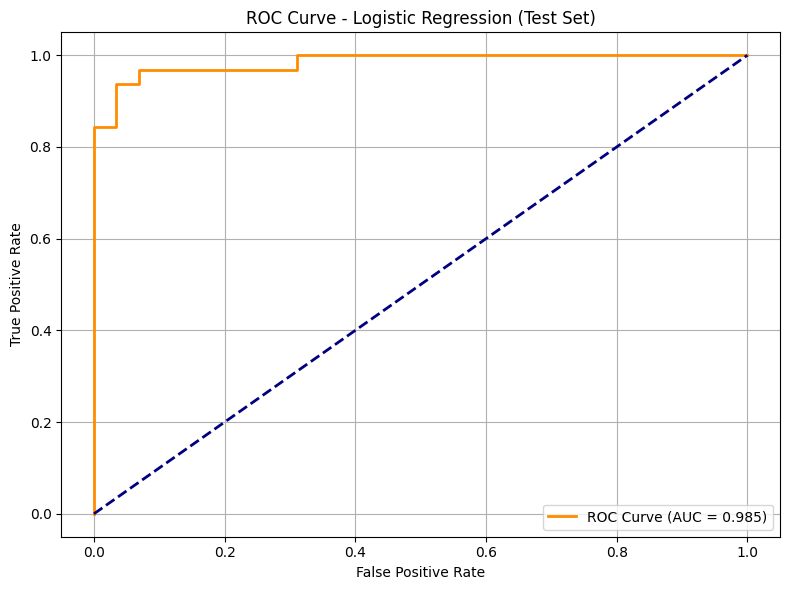

In [448]:
# --------------------
# Evaluation with ROC Curve Plot
# --------------------

print("Logistic Regression - Test Evaluation:")
print(classification_report(y_test, y_pred, target_names=["Classical", "Mesenchymal"]))
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.3f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


# Using Cross Validation 

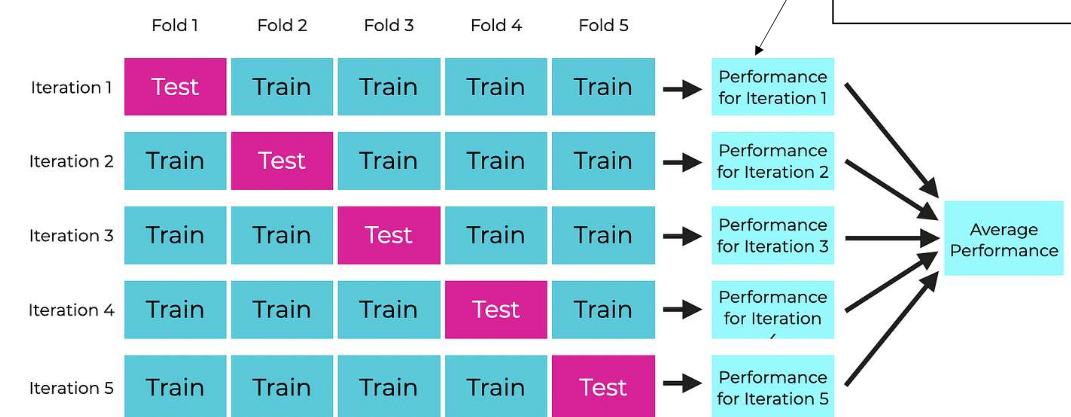

In [449]:
# --------------------
# Define custom scoring
# --------------------
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

In [450]:
X_scaled = standardization(X)

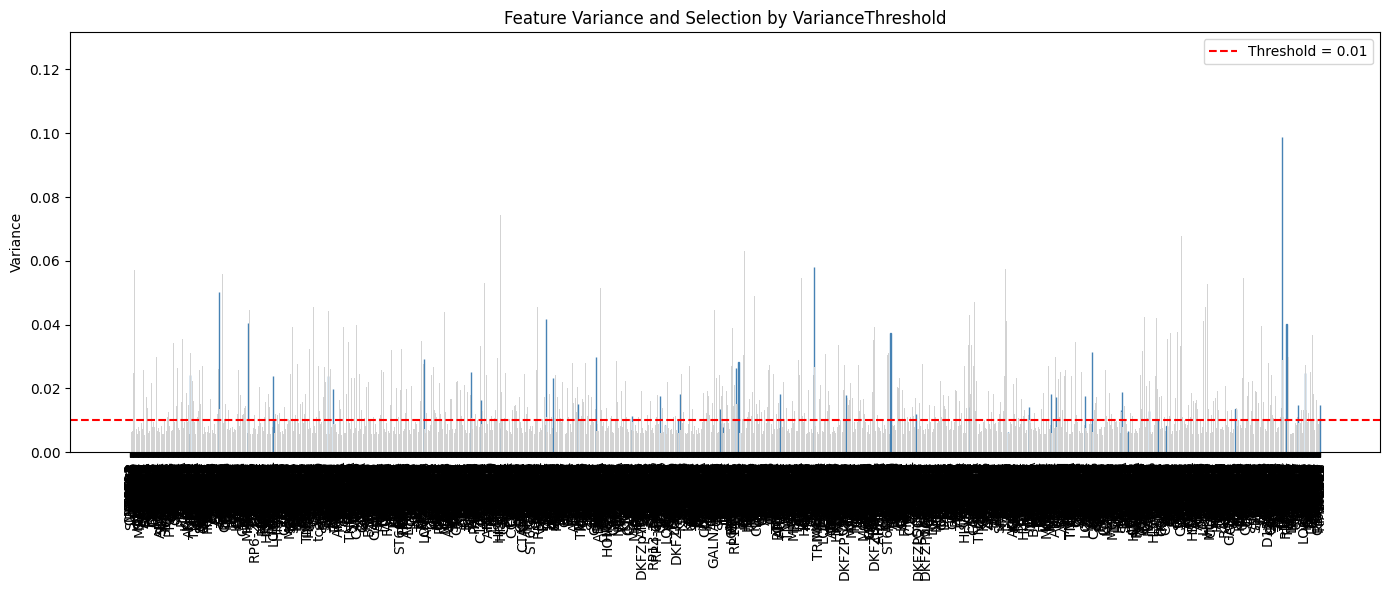

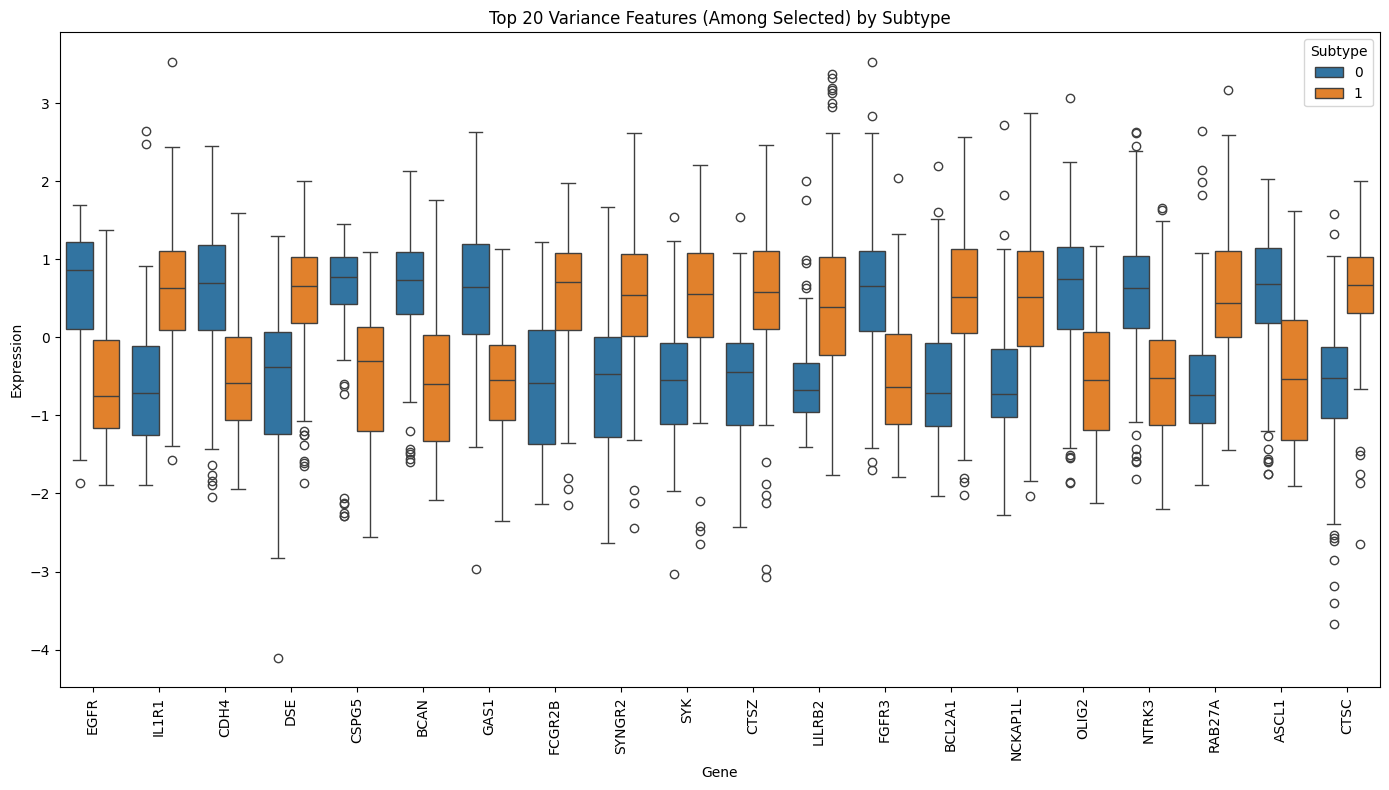

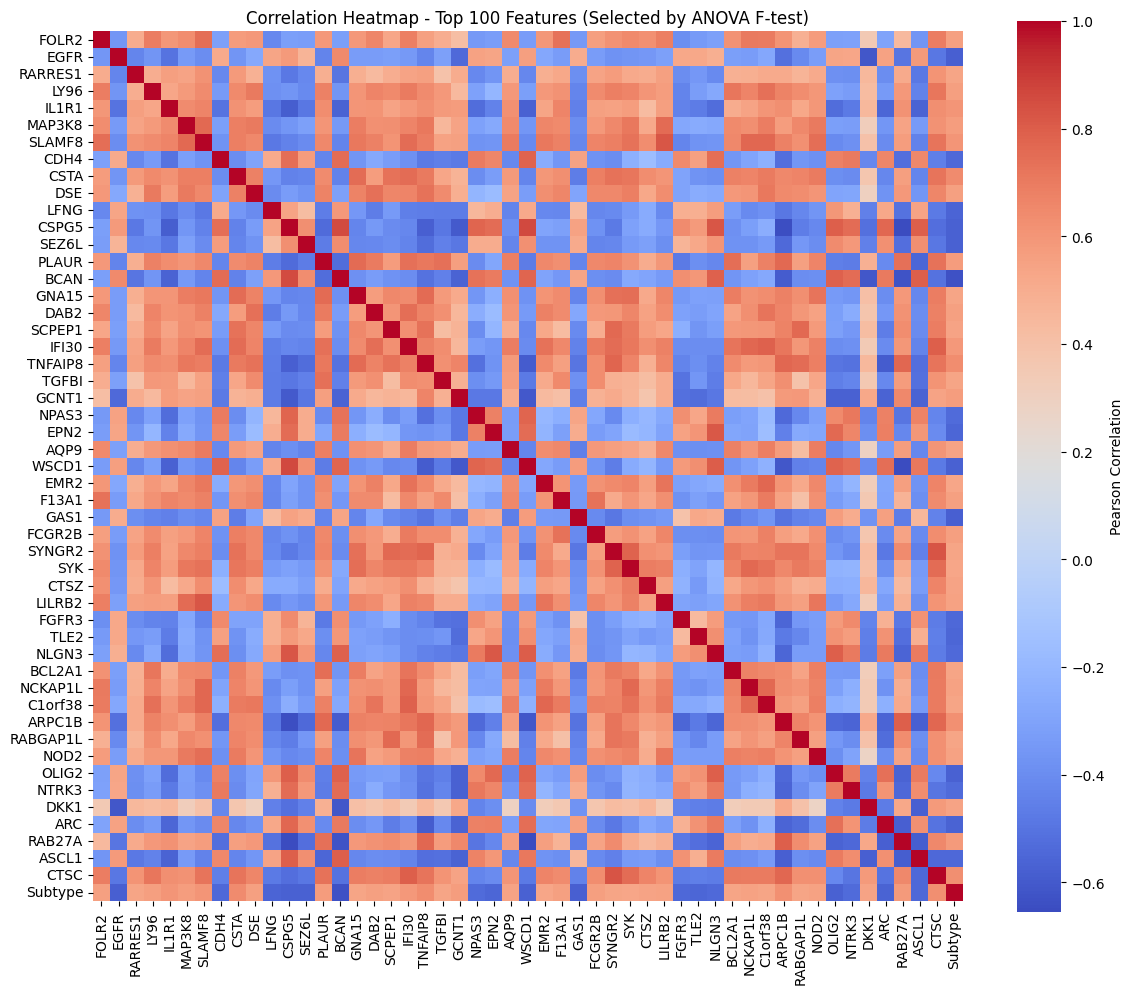


Top 20 Feature Importances (Random Forest):
    Feature  Importance
49     CTSC    0.079519
11    CSPG5    0.070559
14     BCAN    0.070111
8      CSTA    0.063870
25    WSCD1    0.055326
21    GCNT1    0.048141
19  TNFAIP8    0.047074
18    IFI30    0.044296
40   ARPC1B    0.042434
4     IL1R1    0.026097
16     DAB2    0.025071
6    SLAMF8    0.023382
7      CDH4    0.021223
32     CTSZ    0.020412
33   LILRB2    0.018740
28     GAS1    0.017617
23     EPN2    0.017490
12    SEZ6L    0.017389
46      ARC    0.016471
34    FGFR3    0.015609


/var/folders/7_/dhch1whn1nvc26xrz2l7ycjm0000gn/T/ipykernel_99724/277010722.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(20), palette="viridis")


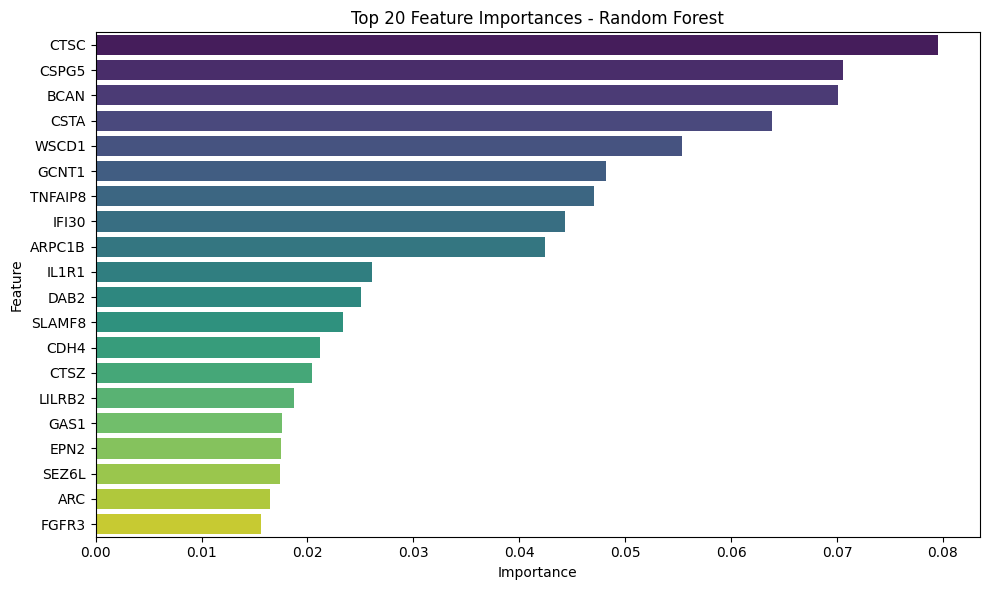

In [451]:
# --------------------
# Feature Selection on Full Data
# --------------------
# 1. Variance Threshold
vt = VarianceThreshold(threshold=0.01)
X_vt = vt.fit_transform(X_scaled)
vt_feature_names = X.columns[vt.get_support()]
X_vt_df = pd.DataFrame(X_vt, columns=vt_feature_names, index=X.index)

# 2. SelectKBest
select_k = 50
fs = SelectKBest(score_func=f_classif, k=select_k)
X_selected = fs.fit_transform(X_vt_df, y)
selected_feature_names = vt_feature_names[fs.get_support()]
X_selected_df = pd.DataFrame(X_selected, columns=selected_feature_names, index=X.index)

# --------------------
# Visualização: Boxplot das features selecionadas (if function exists)
# --------------------
plot_feature_selection(X_selected_df, X_vt_df, y, selected_feature_names, X)

** Random Forest **

In [452]:
# --------------------
# Setup cross-validation
# --------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_data = {}

In [453]:
# --------------------
# Prepare common FPR grid for interpolation
# --------------------
mean_fpr = np.linspace(0, 1, 100)
roc_data_mean = {}

In [454]:
# --------------------
# Logistic Regression with averaged ROC
# --------------------

# Ensure y is a pandas Series
if isinstance(y, np.ndarray):
    y = pd.Series(y)



log_reg_results = []
for C in [0.01, 0.1, 1, 10]:
    model_name = f'LogReg (C={C})'
    pipeline = Pipeline([
        ('select', SelectKBest(score_func=f_classif, k=select_k)),
        ('clf', LogisticRegression(C=C, max_iter=1000))
    ])
    scores = cross_validate(pipeline, X_selected_df, y, cv=cv, scoring=scoring)

    tprs = []
    aucs = []
    for train_idx, val_idx in cv.split(X_selected_df, y):
        X_train, X_val = X_selected_df.iloc[train_idx], X_selected_df.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        pipeline.fit(X_train, y_train)
        y_prob = pipeline.predict_proba(X_val)[:, 1]
        
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        auc = roc_auc_score(y_val, y_prob)
        aucs.append(auc)

        # Interpolate TPR to the common FPR grid
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)

    roc_data_mean[model_name] = (mean_fpr, mean_tpr, mean_auc)

    log_reg_results.append({
        'Model': model_name,
        'ROC AUC': f"{mean_auc:.3f}",
        **{metric: f"{np.mean(scores[f'test_{metric}']):.3f} ± {np.std(scores[f'test_{metric}']):.3f}" 
           for metric in scoring}
    })

In [455]:
# --------------------
# Random Forest with averaged ROC
# --------------------
rf_results = []
for n_estimators in [50, 100, 200]:
    for max_depth in [3, 4, 10, 20]:
        model_name = f'RF (n={n_estimators}, depth={max_depth})'
        pipeline = Pipeline([
            ('select', SelectKBest(score_func=f_classif, k=select_k)),
            ('clf', RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42))
        ])
        scores = cross_validate(pipeline, X_selected_df, y, cv=cv, scoring=scoring)

        tprs = []
        aucs = []
        for train_idx, val_idx in cv.split(X_selected_df, y):
            X_train, X_val = X_selected_df.iloc[train_idx], X_selected_df.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            pipeline.fit(X_train, y_train)
            y_prob = pipeline.predict_proba(X_val)[:, 1]

            fpr, tpr, _ = roc_curve(y_val, y_prob)
            auc = roc_auc_score(y_val, y_prob)
            aucs.append(auc)

            tpr_interp = np.interp(mean_fpr, fpr, tpr)
            tpr_interp[0] = 0.0
            tprs.append(tpr_interp)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs)

        roc_data_mean[model_name] = (mean_fpr, mean_tpr, mean_auc)

        rf_results.append({
            'Model': model_name,
            'ROC AUC': f"{mean_auc:.3f}",
            **{metric: f"{np.mean(scores[f'test_{metric}']):.3f} ± {np.std(scores[f'test_{metric}']):.3f}" 
               for metric in scoring}
        })


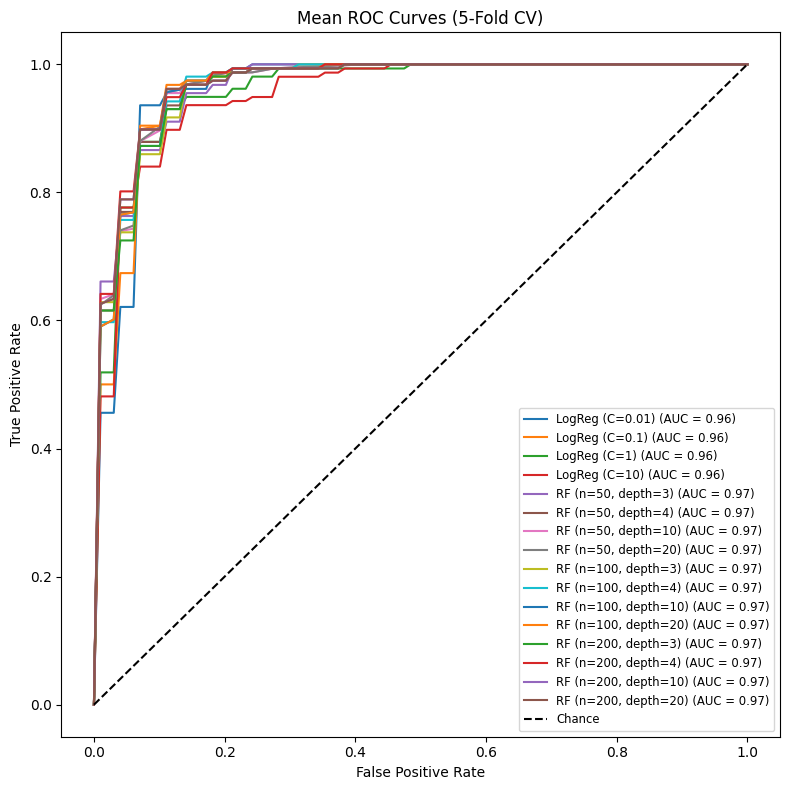

In [456]:
# --------------------
# Plot mean ROC Curves
# --------------------
plt.figure(figsize=(8, 8))  # wider than tall
for label, (fpr, tpr, auc) in roc_data_mean.items():
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Mean ROC Curves (5-Fold CV)")
plt.legend(loc='lower right', fontsize='small')
plt.tight_layout()
plt.show()


In [457]:
# --------------------
# Display CV Results
# --------------------
results_df = pd.DataFrame(log_reg_results + rf_results)
print("\nCross-Validation Results (Full Dataset):")
display(results_df)


Cross-Validation Results (Full Dataset):


,Model,ROC AUC,accuracy,precision,recall,f1
0,LogReg (C=0.01),0.962,0.914 ± 0.029,0.902 ± 0.022,0.936 ± 0.045,0.918 ± 0.029
1,LogReg (C=0.1),0.965,0.924 ± 0.020,0.919 ± 0.015,0.936 ± 0.028,0.927 ± 0.019
2,LogReg (C=1),0.962,0.904 ± 0.019,0.896 ± 0.022,0.924 ± 0.026,0.909 ± 0.018
3,LogReg (C=10),0.955,0.884 ± 0.021,0.887 ± 0.022,0.892 ± 0.033,0.889 ± 0.021
4,"RF (n=50, depth=3)",0.970,0.907 ± 0.017,0.896 ± 0.022,0.930 ± 0.024,0.912 ± 0.016
5,"RF (n=50, depth=4)",0.970,0.914 ± 0.016,0.907 ± 0.018,0.930 ± 0.024,0.918 ± 0.016
6,"RF (n=50, depth=10)",0.970,0.911 ± 0.022,0.902 ± 0.021,0.930 ± 0.037,0.915 ± 0.022
7,"RF (n=50, depth=20)",0.971,0.911 ± 0.022,0.902 ± 0.021,0.930 ± 0.037,0.915 ± 0.022
8,"RF (n=100, depth=3)",0.968,0.911 ± 0.013,0.902 ± 0.020,0.930 ± 0.024,0.915 ± 0.013
9,"RF (n=100, depth=4)",0.970,0.921 ± 0.012,0.908 ± 0.017,0.943 ± 0.023,0.925 ± 0.012
